# Calcul du temps de rémanence
Noé Chassagne, MOLONARI 2023

In [ ]:
import numpy as np
import numpy.linalg as alg
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import scipy.sparse.linalg as sci

### Démonstration de l'évanescence des CI (pour des conditions finales constantes)

Le but de cette partie est de démontrer comment estimer que la perturbation introduite sur les conditions initiales devient suffisamment petite par rapport à la condition finale.

Tout d'abord, on sait que la température suit l'éaution différentielle suivante:

$\frac{dT}{dt} = AT + B$,

Dont on déduit l'équation horaire que T suit:

$T(t) = \exp(At)*(T_0 - T_{\infty}) + T_{\infty}$

Où A est une matrice tridiagonale diagonalisable par des matrices de changement de base orthogonale, $T_0$ et $T_{\infty}$ étant les valeurs finales et initiales de la température. On sait que puisque T tend vers $T_{\infty}$, alors les valeurs propres de A sont nécessairement toute négatives car si $(\lambda_1,...,\lambda_N)$ sont les valeurs propres de A, alors il existe une matrice de changement de base P qui est orhtogonale et une matrice diagonale D dont les coefficients sur la diagonale sont les valeurs propres susnommées telles que:

$A = P*D*P^T$,

Alors on sait que $\exp(At)$ s'exprime comme suit:

$\exp(At) = P*\begin{bmatrix}\exp(\lambda_1 *t) & & \\ & \ddots & \\ & & \exp(\lambda_N *t)\end{bmatrix}*P^T$, en appelant E la matrice diagonale.

On s'intéresse donc au rapport entre la norme de $T_{\infty}$ et celle de Y qui vaut:

$Y = \exp(At)*(T_0 - T_{\infty})$

Pour ce faire, on va prendre pour les vecteurs la norme 2 canonique et pour la matrice, on va prendre la norme triple qui lui est associée. La quantité qui nous intéresse est donc:

\begin{align}
N &= \frac{\lVert Y \rVert _2}{\lVert T_{\infty} \rVert _2} \\
  &= \lVert \exp(At) \rVert  *\frac{\lVert (T_0 - T_{\infty}) \rVert _2}{\lVert T_{\infty} \rVert _2} \\

\end{align}

Pour le premier facteur du produit, on simplifie cette expression en montrant que:

\begin{align}
\lVert \exp(At) \rVert &= sup_{X \in \mathbb(R^N)} \frac{\lVert \exp(At)*X \rVert _2}{\lVert X \rVert _2} \\
  &= sup_{X \in \mathbb(R^N)} \frac{(exp(At)*X)^T * \exp(At) * X}{ X^T * X } \\
  &= sup_{X \in \mathbb(R^N)} \frac{X^T * P * E^2 * P^T * X}{ X^T * P * P^T * X }
\end{align}

Ainsi, en écrivant $Z$ comme $P^T * X$ avec P qui est bijective, on peut réécrire la norme triple comme suit:

\begin{align}
\lVert \exp(At) \rVert &= sup_{Z \in \mathbb(R^N)} \frac{\lVert E*Z \rVert _2}{\lVert Z \rVert _2}
\end{align}

Or, on sait que:

 ${\lVert Z \rVert _2} = (\sum_{i=1}^{n} z_i^2)^{1/2}$ 
 
 et que:
 
 ${\lVert E*Z \rVert _2} = (\sum_{i=1}^{n} (\exp(\lambda_i*t)*z_i)^2)^{1/2}$

 Donc en majorant chaque $\exp(\lambda_i*t)$ par $\exp(\lambda*t)$ avec $\lambda$ qui est définie comme la valeur propre de A la plus grand (sachant que toutes les valeurs propres de A sont négatives car l'équation que suit T converge, $\lambda$ est en fait la valeur propre la plus proche de 0), on obtient que:

\begin{align}
\lVert \exp(At) \rVert &= sup_{Z \in \mathbb(R^N)} \frac{\lVert E*Z \rVert _2}{\lVert Z \rVert _2} \\
  &= sup_{Z \in \mathbb(R^N)} \frac{(\sum_{i=1}^{n} (\exp(\lambda_i*t)*z_i)^2)^{1/2}}{(\sum_{i=1}^{n} z_i^2)^{1/2}} \\
  &\leq \frac{\exp(\lambda *t)(\sum_{i=1}^{n} z_i^2)^{1/2}}{(\sum_{i=1}^{n} z_i^2)^{1/2}} \\
  &\leq \exp(\lambda *t)
\end{align}

De plus, on sait que pour $Z_{\lambda}$ qui est le vecteur propre de E qui correspond à la valeur propre $\exp(\lambda *t)$:

$ \frac{\lVert E*Z_{\lambda} \rVert _2}{\lVert Z_{\lambda} \rVert _2} = \exp(\lambda *t)\frac{\lVert Z_{\lambda} \rVert _2}{\lVert Z \rVert _2}
= \exp(\lambda *t)$

Cette valeur est donc un majorant du sup qui est atteint, c'est donc exactement la norme triple de $\lVert \exp(At) \rVert$.

On a finalement:

$N = \exp(\lambda *t)*\frac{\lVert (T_0 - T_{\infty}) \rVert _2}{\lVert T_{\infty} \rVert _2}$

On voit déjà que la perturbation causée par les conditions initiales est évanescente puisque l'on observe une décroissance exponentielle de N en fonction du temps d'une part, ce qui permet de définir un temps de rémanence qiu estime jusqu'à quand ces conditions initiales influent sur le profil de température le long de la colonne d'eau à un instant donné. Cependant, ce temps de rémanence dépend des régimes que l'on considère, c'est poyrquoi on s'emploiera à trouver un temps de rémanence maximal commun à tous types de régimes et de conditions initiales. Pour cela on réalise des tests de vitesse de convergence en utilisant le calcul direct.

### Exemple de décroissance de N au cours du temps:

In [ ]:
class EvolutionMatrix:
    
    def __init__(self,N:int,sizes:np.array)->None:
        
        self.Lc = sizes[1:-1]**(-1)
        self.Le = ((sizes[:-1] + sizes[1:])/2)**(-1)
        self.P = np.array([1/(1/sizes[i]+1/sizes[i+1]) for i in range(N+1)])
        self.e1 = np.zeros(N)
        self.e1[0] = 1
        self.eN = np.zeros(N)
        self.eN[N-1] = 1
        self.N = N
            
    def compute_A(self,K:np.array,Lambda:np.array,C:np.array,nablaH:np.array,cw=4180,rhow=1000)->np.array:
        
        SDS = self.Le*Lambda
        SDA = -cw*rhow*K*nablaH*self.P
        
        SubD = SDS[1:self.N] + SDA[1:self.N]
        D = -SDS[1:] - SDS[:self.N] + self.Lc*(SDA[:N]-SDA[1:])
        SupD = SDS[1:self.N] - SDA[1:self.N]
        
        return C**(-1)*self.Lc*(np.diag(SubD,k=-1)+np.diag(D,k=0)+np.diag(SupD,k=1))
    
    def compute_B(self,K:np.array,Lambda:np.array,C:np.array,nablaH:np.array,Tbound:np.array,cw=4180,rhow=1000)->np.array:
        
        coefB0 = (self.Le[0]*Lambda[0]-cw*rhow*K[0]*nablaH[0]*self.P[0])/C[0]*self.Lc[0]
        coefBN =  (self.Le[self.N]*Lambda[self.N]+cw*rhow*K[self.N]*nablaH[self.N]*self.P[self.N])/C[self.N-1]*self.Lc[self.N-1]
        
        return coefB0*Tbound[0]*self.e1+coefBN*Tbound[1]*self.eN

In [ ]:
#parametres physiques de la simulation test
h = 0.6
nablaH, K = 0.05, 10**(-5)
cw, rhow = 4180, 1000
lambm = 3
crhom = 4*10**6
days = 1
P = days*24*3600
thmu, thamp = 273.15+12, 1

In [ ]:
N = 28
l = h/(N+2)
Z = np.linspace(0,h,N+2)

sizes = l*np.ones(N+2)

evol_matrix = EvolutionMatrix(N,sizes)
s = np.ones(N+1)

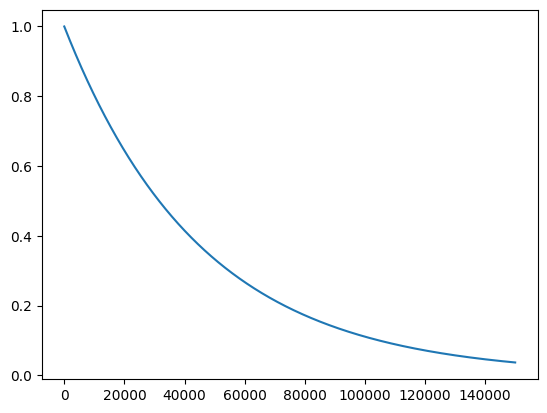

In [ ]:
A = evol_matrix.compute_A(K*s,lambm*s,crhom*s[:-1],nablaH*s)
Vp = np.array(alg.eigvals(A)) #eigsh
l_m = np.max(Vp)

X_0 = np.array([274]*N)
X_f = np.array([283]*N)
norme_0 = np.sqrt(np.vdot(X_0 - X_f, X_0 - X_f)/np.vdot(X_f, X_f))


def f_neg(t,X_0 = X_0,X_f = X_f):
    norme =  np.exp(l_m*t)*np.sqrt(np.vdot(X_0 - X_f, X_0 - X_f)/np.vdot(X_f, X_f))
    return norme

T = [k for k in range(15*10**4)]
F = [f_neg(t) for t in T]*1/norme_0
plt.plot(T,F)
plt.plot()
plt.show()

### Profil final sur les différents régimes:

On constate tout d'abord que les profils des températures finales n'évoluent plus significativement pour K qui dépasse $ 10^{-6}$, il suffit donc de prendre le temps de rémanence maximal entre ces deux réimes, en prenant des conditions initiales volontairement éloignées afin de s'assurer de majorer le temps de rémanence dans tous les cas.

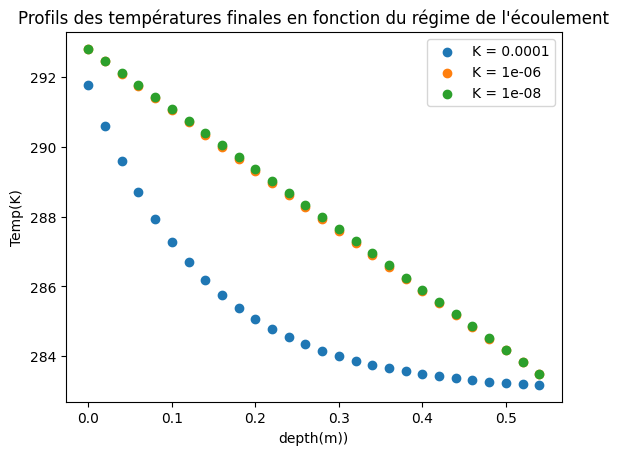

In [ ]:
L_K = [10**(-4),10**(-6),10**(-8)]
Triv = 20 + 273.15
Tnap = 10 + 273.15
Z = [(k/50) for k in range(N)]

for K in L_K:

    #A
    l = h/(N+1)
    q = -K*nablaH

    #diagonals coefficients
    a = lambm/(l**2) + (q*cw*rhow)/(2*l)

    b = -2*lambm/(l**2)

    c = lambm/(l**2) - (q*cw*rhow)/(2*l)

    DD = a*np.diag(np.ones(N-1),-1)
    D = b*np.diag(np.ones(N),0)
    UD = c*np.diag(np.ones(N-1),1)

    A0 = DD + D + UD

    #L

    Lriv = np.zeros(N)
    Lriv[0] = a
    Lnap = np.zeros(N)
    Lnap[-1] = c        
    L0 =Triv*Lriv + Tnap*Lnap

    Temp = -np.linalg.inv(A0).dot(L0)
    plt.scatter(Z,Temp, label = f'K = {K}')

plt.xlabel('depth(m))')
plt.ylabel('Temp(K)')
plt.title("Profils des températures finales en fonction du régime de l'écoulement")
plt.legend()
plt.show()

### Valeur du temps de rémanence via le calcul direct

Pour K = $10^{-4}$, en utilisant le calcul direct, on se rend compte que pour tout profil de température constant en condition initiale qui soit cohérent, on converge pour t = 25000s (à peu près un quart de cycle nycthéméral) ce qui correspond à peu près à la valeur de N qui est divisée par $\exp(1)$ par rapport à sa valeur initiale, i.e pour $t = \frac{1}{-\lambda}$.

Pour K = $10^{-6}$, en utilisant le calcul direct, on se rend compte que pour tout profil de température constant en condition initiale, on converge pour t = 55000s (à peu près deux tiers d'un cycle nycthéméral) ce qui correspond à peu près à la valeur de N qui est divisée par 10 par rapport à sa valeur initiale, i.e pour $t = \frac{ln(10)}{-\lambda}$.

On peut donc prendre un temps de une journée (86400s) pour le temps de rémanence maximal qui majore les deux valeurs précédentes.

On a aussi essayer de calculer des temps de rémanence en créant des profils plus vraisemblables de conditions initiales mais ce derniers étant initialement moins éloignés des conditions finales à atteindre convergeaient pour des temps très faible en comparaison des temps susmentionnés.

In [ ]:
# programme d'interpolation linéaire entre les différents points du profil final correspondant à ceux du capteur molonari
Temp = Temp
T01 = [(Temp[0] + k*(Temp[4] - Temp[0])/5) for k in range(1,6)]
T02 = [(Temp[4] + k*(Temp[9] - Temp[4])/5)for k in range(1,6)]
T03 = [(Temp[9] + k*(Temp[14] - Temp[9])/5)for k in range(1,6)]
T04 = [(Temp[14] + k*(Temp[19] - Temp[14])/5)for k in range(1,6)]

T0 = T01 + T02 + T03 + T04
print(T0)

[292.3084687903087, 292.0877425524678, 291.8670163146268, 291.6462900767859, 291.4255638389449, 291.0807014615044, 290.73583908406385, 290.39097670662335, 290.0461143291828, 289.7012519517423, 289.35641442728104, 289.0115769028198, 288.6667393783585, 288.32190185389726, 287.977064329436, 287.6322516561629, 287.28743898288974, 286.9426263096166, 286.59781363634346, 286.25300096307035]


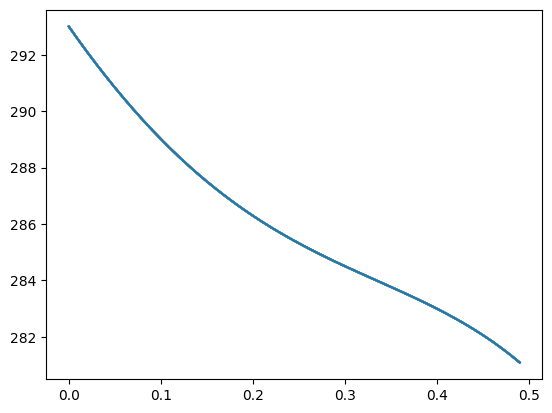

In [ ]:
def lagrange_interpolation(x_values, y_values):
    n = len(x_values)
    if n != len(y_values) or n < 1:
        raise ValueError("Les listes x_values et y_values doivent avoir la même longueur et être non vides.")

    def L(k, x):
        result = 1.0
        for i in range(n):
            if i != k:
                result *= (x - x_values[i]) / (x_values[k] - x_values[i])
        return result

    def interpolate(x):
        if len(x) == 1:
            x = x[0]
            result = 0.0
            for k in range(n):
                result += y_values[k] * L(k, x)
            return result
        else:
            result = [interpolate(xi) for xi in x]
            return result

    return interpolate

# Exemple d'utilisation :
x_values = [0, 0.1, 0.2, 0.3, 0.4]
y_values = [293, 289.01304182, 286.29375035, 284.5063148, 283]
interpolate_function = lagrange_interpolation(x_values, y_values)
Z = [k/100 for k in range(50)]
T = [interpolate_function([k/100]) for k in range(50)]

plt.plot(Z,T)
plt.show()


### Conditions finales qui dépendent du temps (optionnel)

Lorsque $A$ est constante (par rapport au temps et aux températures), alors la solution de l'équation $\dot{T}=AT+L$ admet comme solution $$T(t) = \exp(At)\left(\int_{0}^{t}\exp(-Au)L(u)du+T_{init}\right)$$
calculable relativement efficacement grâce à une diagonalisation de $A$

On essaie de nouveau de calculer N et on obtient cette fois-ci: $N = \frac{\lVert (\int_{0}^{t}\exp(-Au)L(u)du) \rVert _2}{\lVert T_{init} \rVert _2}$

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.misc
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import display
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()

In [ ]:
class CAMatrix:
    #Conduction-Advection-Matrix

    def __init__(self,N,h,rhow,rhos,cw,cs,g,lambs,lambw,n,k,muw,deltH,Triv,Tnap):
        self.N = N
        self.h = h
        self.rhow = rhow
        self.cw = cw
        self.g = g
        self.lambs = lambs
        self.lambw = lambw
        self.n = n
        self.lambm = (self.n*(self.lambw)**0.5 +(1-self.n)*(self.lambs)**0.5)**2
        self.k = k
        self.muw = muw
        self.deltH = deltH
        self.nablH = self.deltH/self.h
        self.K = (self.k*self.rhow*self.g)/self.muw
        self.q = -self.K*self.nablH
        self.crhom = n*cw*rhow+(1-n)*cs*rhos
        self.Triv = Triv
        self.Tnap = Tnap
        self.Z = self.h/(self.N+1)*np.arange(1,self.N+1)
        
    def RP_analytic(self,z):
        #when dT/dt = 0, temperature curve is an exponential
        
        gamma = self.cw*self.rhow*self.q/self.lambm
        det = 1-np.exp(gamma*self.h)
        alpha = (self.Triv(0)-self.Tnap(0))/det
        beta = (self.Tnap(0)-np.exp(gamma*self.h)*self.Triv(0))/det
        
        return alpha*np.exp(gamma*z)+beta

    def make_A(self):

        #distance between two cells
        l = self.h/(self.N+1)

        #diagonals coefficients
        a = self.lambm/(l**2) + (self.q*self.cw*self.rhow)/(2*l)
        self.a = a
        b = -2*self.lambm/(l**2)
        self.b = b
        c = self.lambm/(l**2) - (self.q*self.cw*self.rhow)/(2*l)
        self.c = c

        #building diagonals
        DD = a*np.diag(np.ones(self.N-1),-1)
        D = b*np.diag(np.ones(self.N),0)
        UD = c*np.diag(np.ones(self.N-1),1)

        #building the matrix
        self.A = DD + D + UD
    
    def make_L(self):        
        #building the conditions at the frontier
        
        Lriv = np.zeros(self.N)
        Lriv[0] = self.a
        Lnap = np.zeros(self.N)
        Lnap[-1] = self.c        
        self.L = lambda t : self.Triv(t)*Lriv + self.Tnap(t)*Lnap

    def RP_solve(self):
        #solve the discrete problem when dT/dt = 0
        
        self.T = np.linalg.solve(self.A,-self.L(0))
        
    def implicit_solve(self,Tinit,times):
        #implicit Euler method
        
        self.T = Tinit
        n = len(times)
        self.times = times
        self.memo = np.empty((n+1,self.N))
        self.memo[0] = Tinit
        for i in range(0,n-1):
            t0,t1 = times[i],times[i+1]
            dt = t1-t0
            self.T = np.linalg.solve(np.identity(self.N)-(dt/self.crhom)*self.A,self.T+(dt/self.crhom)*self.L(t1))
            self.memo[i+1] = self.T.copy()
            
    def diagonalize(self):
        eigenvalues, eigenvectors = np.linalg.eig(self.A)
        self.D = np.diag(eigenvalues)
        self.H = eigenvectors
        self.invH = np.linalg.inv(self.H)
        
    def diag_solve(self,Tinit,times):
        #computes the exact solution of discrete problem using diagonalization
        
        diag = np.diag(self.D)/self.crhom      
        aux = lambda x : np.dot(self.H,np.dot(np.diag(np.exp(x*diag)),self.invH))
        auxi = lambda t,x : np.dot(np.dot(self.H,np.dot(np.diag(np.exp((t-x)*diag)),self.invH)),self.L(x)/self.crhom)
        self.times = times
        self.memo = np.empty((len(times),self.N))
        for i,t in enumerate(times):
            if i>0:
                self.memo[i] = scipy.integrate.quad_vec(lambda x : auxi(t,x),times[i-1],t)[0]+np.dot(aux(t-times[i-1]),self.memo[i-1])
            else:
                self.memo[i] = scipy.integrate.quad_vec(lambda x : auxi(t,x),0,t)[0]+np.dot(aux(t),Tinit)
            
    def RP_display(self):
        plt.figure()
        Z = np.arange(1,self.N+1)*self.h/(self.N+1)
        plt.scatter(Z,self.T,label='approx')
        plt.plot(Z,np.vectorize(self.RP_analytic)(Z),label='analytic')
        plt.xlabel("depth [m]")
        plt.ylabel("temperature [K]")
        plt.legend()
        plt.show()
    
    def display(self,figsize=(3,3),compar=False):
        fig = plt.figure(figsize=figsize)
        for i,t in enumerate(self.times):
            plt.scatter(self.Z,self.memo[i],color=((1.1-i/len(self.memo))/1.1,0,0))
            if compar:
                plt.plot(self.Z,self.compar[i],color=((1.1-i/len(self.memo))/1.1,0,0))
        plt.xlabel("depth")
        plt.ylabel("temperature")
        plt.title(f'de 0 s (rouge clair) à tf = {np.round(self.times[-1]/(24*3600),2)} jours (rouge sombre)')
        plt.show()
        
    def live_display(self,xmin,xmax,ymin,ymax,interval=200):
        fig, ax = plt.subplots()
        scat = ax.scatter(self.Z, self.memo[0])        
        ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax],xlabel='depth [m]', ylabel='temperature [K]')
        
        def update(frame):
            #update the scatter plot
            data = np.stack([self.Z, self.memo[frame]]).T
            scat.set_offsets(data)
            scat.set_color(((1.1-frame/len(self.times))/1.1,0,0))
            return scat
        
        ani = animation.FuncAnimation(fig=fig, func=update, frames=len(self.times),interval=interval)
        display(HTML(ani.to_jshtml()))

    def export_csv(self,name:str):
        df = pd.DataFrame(self.T)
        df.to_csv(name+'.csv')

    def RP_do_all(self, K= -1, lambm=-1, n=-1,display=True):
        
        if K >= 0:
            self.K = K
        if lambm>=0:
            self.lambm = lambm
        if n>=0:
            self.n = n
        
        #setup
        self.make_A()
        self.make_L()
        
        #compute and show
        self.RP_solve()
        self.RP_display()
        
    def do_all(self,Tinit,times,meth='implicit',figsize=(4,3),fcompar=None, K=-1, lambm=-1, n=-1):
        if K >= 0:
            self.K = K
        if lambm>=0:
            self.lambm = lambm
        if n>=0:
            self.n = n
        
        #setup
        self.make_A()
        self.make_L()
        
        #compute with the right method
        if meth=='implicit':
            self.implicit_solve(Tinit,times)
        elif meth=='diag':
            self.diagonalize()
            self.diag_solve(Tinit,times)
            
        if fcompar!=None:
            #typically to compare with an analytic solution like Stallman solution
            self.compar = np.empty((len(times),self.N))
            for i,t in enumerate(times):
                self.compar[i] = np.vectorize(lambda z:fcompar(z,t))(self.Z)
            self.display(figsize=figsize,compar=True)
        else:
            self.display(figsize=figsize,compar=False)
    
    def norme_2(self, Tinit, t):
        diag = np.diag(self.D) / self.crhom
        aux = lambda x: np.dot(self.H, np.dot(np.diag(np.exp(x * diag)), self.invH))
        auxi = lambda x: np.dot(np.dot(self.H, np.dot(np.diag(np.exp(-x * diag)), self.invH)), self.L(x) / self.crhom)
        
        # Calcul de l'intégrale \int_{0}^{t}exp(-Au)L(u)du
        integral_result = scipy.integrate.quad_vec(lambda x: auxi(x), 0, t)[0]
        
        # Calcul de l'expression finale
        norm_2 = np.linalg.norm(np.exp(t * diag).dot(integral_result) + Tinit)
        
        return norm_2


In [ ]:
N, h = 20, 1
rhow, rhos = 1000, 2000
cw, cs = 4180, 800
lambw, lambs = 0.6, 3
n = 0.2
k, g, muw, deltH = 10**(-12), 10, 10**(-3), 0.25
Triv = lambda t : 20 + 273.15
Tnap = lambda t : 10 + 273.15

CAM = CAMatrix(N,h,rhow,rhos,cw,cs,g,lambs,lambw,n,k,muw,deltH,Triv,Tnap)
CAM.make_A()
CAM.diagonalize()

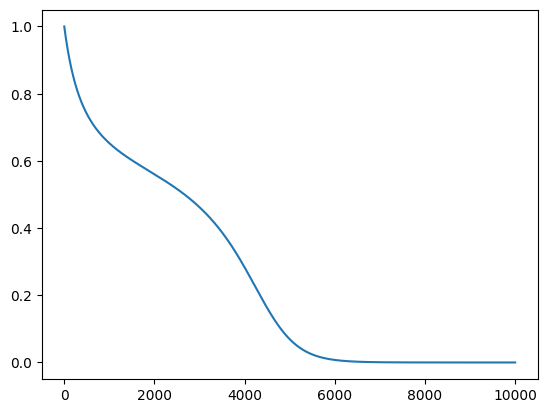

In [ ]:
CAM.make_L()
Tinit = np.array([273]*N)

def rapport(Tinit, t):

    N_Tinit = np.sqrt(np.vdot(Tinit,Tinit))
    N_sol_f = CAM.norme_2(Tinit,t)
    
    return N_Tinit/N_sol_f

T = [t for t in range(10**4)]
R = [rapport(Tinit,t) for t in T]

plt.plot(T,R)
plt.show()

On remarque ici un temps de convergence qui avoisine les 6000 secondes donc inférieurs aux durées précédentes. Cependant la durée de convergence semble étonnamment petite en comparaison avec celles pour un profil final constant. On cherche donc à caractériser d'une façon différente ce temps de rémanence. 

### Tentative de caractérisation de la rémanence via un calcul de correlation des profils

Pour ce faire on va se baser sur une méthode qui consiste à prendr un profil initial et un profil final totalement décorrélés et de regarder à partir de quel moment le profil initial ainsi que le profil de température à un instant donné ne sont plus corrélés. Pour ce faire, on utilise le coefficient de correlation de Pearson entre ces deux jeux de données.

In [ ]:
class CAMatrix2: 
    #Conduction-Advection-Matrix

    def __init__(self,N,h,rhow,rhos,cw,cs,g,lambs,lambw,n,k,muw,deltH,Triv,Tnap):
        self.N = N
        self.h = h
        self.rhow = rhow
        self.cw = cw
        self.g = g
        self.lambs = lambs
        self.lambw = lambw
        self.n = n
        self.lambm = (self.n*(self.lambw)**0.5 +(1-self.n)*(self.lambs)**0.5)**2
        self.k = k
        self.muw = muw
        self.deltH = deltH
        self.nablH = self.deltH/self.h
        self.K = (self.k*self.rhow*self.g)/self.muw
        self.q = -self.K*self.nablH
        self.crhom = n*cw*rhow+(1-n)*cs*rhos
        self.Triv = Triv
        self.Tnap = Tnap
        self.Z = self.h/(self.N+1)*np.arange(1,self.N+1)
        
    def RP_analytic(self,z):
        #when dT/dt = 0, temperature curve is an exponential
        
        gamma = self.cw*self.rhow*self.q/self.lambm
        det = 1-np.exp(gamma*self.h)
        alpha = (self.Triv(0)-self.Tnap(0))/det
        beta = (self.Tnap(0)-np.exp(gamma*self.h)*self.Triv(0))/det
        
        return alpha*np.exp(gamma*z)+beta

    def make_A(self):

        #distance between two cells
        l = self.h/(self.N+1)

        #diagonals coefficients
        a = self.lambm/(l**2) + (self.q*self.cw*self.rhow)/(2*l)
        self.a = a
        b = -2*self.lambm/(l**2)
        self.b = b
        c = self.lambm/(l**2) - (self.q*self.cw*self.rhow)/(2*l)
        self.c = c

        #building diagonals
        DD = a*np.diag(np.ones(self.N-1),-1)
        D = b*np.diag(np.ones(self.N),0)
        UD = c*np.diag(np.ones(self.N-1),1)

        #building the matrix
        self.A = DD + D + UD
    
    def make_L(self):        
        #building the conditions at the frontier
        
        Lriv = np.zeros(self.N)
        Lriv[0] = self.a
        Lnap = np.zeros(self.N)
        Lnap[-1] = self.c        
        self.L = lambda t : self.Triv(t)*Lriv + self.Tnap(t)*Lnap

    def RP_solve(self):
        #solve the discrete problem when dT/dt = 0
        
        self.T = np.linalg.solve(self.A,-self.L(0))
        
    def implicit_solve(self,Tinit,times):
        #implicit Euler method
        
        self.T = Tinit
        n = len(times)
        self.times = times
        self.memo = np.empty((n+1,self.N))
        self.memo[0] = Tinit
        for i in range(0,n-1):
            t0,t1 = times[i],times[i+1]
            dt = t1-t0
            self.T = np.linalg.solve(np.identity(self.N)-(dt/self.crhom)*self.A,self.T+(dt/self.crhom)*self.L(t1))
            self.memo[i+1] = self.T.copy()
            
    def diagonalize(self):
        eigenvalues, eigenvectors = np.linalg.eig(self.A)
        self.D = np.diag(eigenvalues)
        self.H = eigenvectors
        self.invH = np.linalg.inv(self.H)
        
    def diag_solve(self,Tinit,times):
        #computes the exact solution of discrete problem using diagonalization
        
        diag = np.diag(self.D)/self.crhom      
        aux = lambda x : np.dot(self.H,np.dot(np.diag(np.exp(x*diag)),self.invH))
        auxi = lambda t,x : np.dot(np.dot(self.H,np.dot(np.diag(np.exp((t-x)*diag)),self.invH)),self.L(x)/self.crhom)
        self.times = times
        self.memo = np.empty((len(times),self.N))
        for i,t in enumerate(times):
            if i>0:
                self.memo[i] = scipy.integrate.quad_vec(lambda x : auxi(t,x),times[i-1],t)[0]+np.dot(aux(t-times[i-1]),self.memo[i-1])
            else:
                self.memo[i] = scipy.integrate.quad_vec(lambda x : auxi(t,x),0,t)[0]+np.dot(aux(t),Tinit)
        return self.memo
            
    def RP_display(self):
        plt.figure()
        Z = np.arange(1,self.N+1)*self.h/(self.N+1)
        plt.scatter(Z,self.T,label='approx')
        plt.plot(Z,np.vectorize(self.RP_analytic)(Z),label='analytic')
        plt.xlabel("depth [m]")
        plt.ylabel("temperature [K]")
        plt.legend()
        plt.show()
    
    def display(self,figsize=(3,3),compar=False):
        fig = plt.figure(figsize=figsize)
        for i,t in enumerate(self.times):
            plt.scatter(self.Z,self.memo[i],color=((1.1-i/len(self.memo))/1.1,0,0))
            if compar:
                plt.plot(self.Z,self.compar[i],color=((1.1-i/len(self.memo))/1.1,0,0))
        plt.xlabel("depth")
        plt.ylabel("temperature")
        plt.title(f'de 0 s (rouge clair) à tf = {np.round(self.times[-1]/(24*3600),2)} jours (rouge sombre)')
        plt.show()
        
    def live_display(self,xmin,xmax,ymin,ymax,interval=200):
        fig, ax = plt.subplots()
        scat = ax.scatter(self.Z, self.memo[0])        
        ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax],xlabel='depth [m]', ylabel='temperature [K]')
        
        def update(frame):
            #update the scatter plot
            data = np.stack([self.Z, self.memo[frame]]).T
            scat.set_offsets(data)
            scat.set_color(((1.1-frame/len(self.times))/1.1,0,0))
            return scat
        
        ani = animation.FuncAnimation(fig=fig, func=update, frames=len(self.times),interval=interval)
        display(HTML(ani.to_jshtml()))

    def export_csv(self,name:str):
        df = pd.DataFrame(self.T)
        df.to_csv(name+'.csv')

    def RP_do_all(self, K= -1, lambm=-1, n=-1,display=True):
        
        if K >= 0:
            self.K = K
        if lambm>=0:
            self.lambm = lambm
        if n>=0:
            self.n = n
        
        #setup
        self.make_A()
        self.make_L()
        
        #compute and show
        self.RP_solve()
        self.RP_display()
        
    def do_all(self,Tinit,times,meth='implicit',figsize=(4,3),fcompar=None, K=-1, lambm=-1, n=-1):
        if K >= 0:
            self.K = K
        if lambm>=0:
            self.lambm = lambm
        if n>=0:
            self.n = n
        
        #setup
        self.make_A()
        self.make_L()
        
        #compute with the right method
        if meth=='implicit':
            self.implicit_solve(Tinit,times)
        elif meth=='diag':
            self.diagonalize()
            self.diag_solve(Tinit,times)
            
        if fcompar!=None:
            #typically to compare with an analytic solution like Stallman solution
            self.compar = np.empty((len(times),self.N))
            for i,t in enumerate(times):
                self.compar[i] = np.vectorize(lambda z:fcompar(z,t))(self.Z)
            self.display(figsize=figsize,compar=True)
        else:
            self.display(figsize=figsize,compar=False)
    
    def norme_2(self, Tinit, t):
        diag = np.diag(self.D) / self.crhom
        aux = lambda x: np.dot(self.H, np.dot(np.diag(np.exp(x * diag)), self.invH))
        auxi = lambda x: np.dot(np.dot(self.H, np.dot(np.diag(np.exp(-x * diag)), self.invH)), self.L(x) / self.crhom)
        
        # Calcul de l'intégrale \int_{0}^{t}exp(-Au)L(u)du
        integral_result = scipy.integrate.quad_vec(lambda x: auxi(x), 0, t)[0]
        
        # Calcul de l'expression finale
        norm_2 = np.linalg.norm(np.exp(t * diag).dot(integral_result) + Tinit)
        
        return norm_2


In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Définissez la classe CAMatrix avec ses méthodes.

N, h = 20, 1
rhow, rhos = 1000, 2000
cw, cs = 4180, 800
lambw, lambs = 0.6, 3
n = 0.2
k, g, muw, deltH = 10**(-12), 10, 10**(-3), 0.25
Triv = lambda t : 20 + 273.15
Tnap = lambda t : 10 + 273.15

CAM = CAMatrix2(N,h,rhow,rhos,cw,cs,g,lambs,lambw,n,k,muw,deltH,Triv,Tnap)

def generate_gaussian_noise(mean, std_dev, size):
    """
    Génère du bruit gaussien (blanc) avec une moyenne et un écart-type donnés.
    
    :param mean: Moyenne de la distribution gaussienne
    :param std_dev: Écart-type de la distribution gaussienne
    :param size: Taille de l'échantillon de bruit à générer
    :return: Tableau NumPy contenant le bruit généré
    """
    noise = np.random.normal(mean, std_dev, size)
    return noise


def X(t):
    return CAM.diag_solve(X_0_noise,t)


N = 20  # Par exemple, choisissez une valeur pour N
X_0_noise = generate_gaussian_noise(0, 1, N)  # Générez un bruit gaussien

CAM.make_A()
CAM.diagonalize()
CAM.make_L()


In [ ]:
def Corr(t, X_0):
    st = np.std(X(t))
    sf = np.std(X_0)
    cov_matrix = np.cov(X(t), X_0)
    return cov_matrix[0, 1] / (st * sf)

In [ ]:
def Infl(X_0, seuil):
    T = [k for k in range(10**4)]
    compt = 1
    while np.abs(Corr(T[:compt], X_0)) > seuil:
        compt += 1
    return compt


influence = Infl(X_0_noise, 0.1)
print("Influence estimate:", influence)
# pour 0.1, Pearson ne marche pas: en gros 500 à la place de 6000

KeyboardInterrupt: 

On remarque que même en mettant un coefficient de corrélation seuil de 0.1 pour estimer la décorrélation (ce qui est faux puisque deux jeux de données peuvent être décorrélés pour des valeurs de coefficient bien plus élevées), on obtient un temps de rémanence qui n'est pas du tout à la même échelle que les précédents. Cela vient sans doute du fait que si un profil n'est en apparence pas corrélé avec les données initiales, il ne l'est pas forcément avec les données finales.

Pour s'assurer de la validité du temps de 6000 secondes, on pourrait essayer de s'intéresser à la valeur trouver empiriquement par le calcul direct avec des CF qui varient dans le temps, ou trouver une autre méthode de quantification de ce temps via une autre méthode.